In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Dataset retrieval via Kaggle API
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'
with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print('The dataset is extracted')

The dataset is extracted


In [5]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score

In [8]:
with_mask_dir = '/content/data/with_mask/'
without_mask_dir = '/content/data/without_mask/'

with_mask_images = os.listdir(with_mask_dir)
without_mask_images = os.listdir(without_mask_dir)

print(with_mask_images[0:5])
print(with_mask_images[-5:])
print(without_mask_images[0:5])
print(without_mask_images[-5:])

['with_mask_1601.jpg', 'with_mask_1410.jpg', 'with_mask_647.jpg', 'with_mask_1391.jpg', 'with_mask_841.jpg']
['with_mask_1400.jpg', 'with_mask_3552.jpg', 'with_mask_2194.jpg', 'with_mask_2845.jpg', 'with_mask_1421.jpg']
['without_mask_2439.jpg', 'without_mask_3651.jpg', 'without_mask_2510.jpg', 'without_mask_363.jpg', 'without_mask_3403.jpg']
['without_mask_1503.jpg', 'without_mask_3185.jpg', 'without_mask_945.jpg', 'without_mask_1038.jpg', 'without_mask_3040.jpg']


In [9]:
print('Number of with mask images:', len(with_mask_images))
print('Number of without mask images:', len(without_mask_images))

Number of with mask images: 3725
Number of without mask images: 3828


In [10]:
with_mask_label = [0] * len(with_mask_images)
without_mask_label = [1] * len(without_mask_images)
labels = with_mask_label + without_mask_label

print(len(labels))
print(labels[0:5])
print(labels[-5:])

7553
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1]


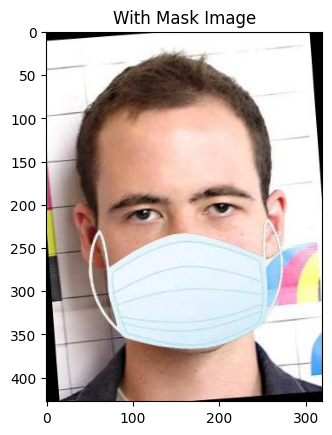

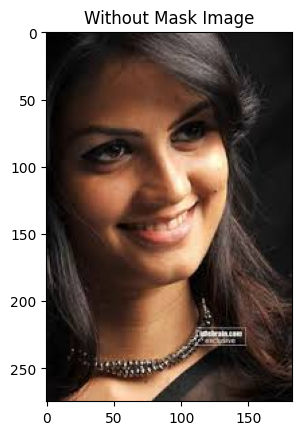

In [11]:
# Displaying with_mask image
image = mpimg.imread('/content/data/with_mask/with_mask_1839.jpg')
plot = plt.imshow(image)
plt.title(('With Mask Image'))
plt.show()

# Displaying without_mask image
image = mpimg.imread('/content/data/without_mask/without_mask_1881.jpg')
plot = plt.imshow(image)
plt.title(('Without Mask Image'))
plt.show()

In [12]:
# Converting images to numpy
all_images = []
for img_file in with_mask_images:
    img = Image.open(with_mask_dir + img_file)
    img = img.resize((128, 128)).convert('RGB')
    all_images.append(np.array(img))

for img_file in without_mask_images:
    img = Image.open(without_mask_dir + img_file)
    img = img.resize((128, 128)).convert('RGB')
    all_images.append(np.array(img))

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
type(all_images)

list

In [14]:
len(all_images)

7553

In [15]:
all_images[0].shape

(128, 128, 3)

In [16]:
x = np.array(all_images) / 255.0
y = np.array(labels)

In [17]:
# Train Test split - 70-30
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=10)

In [18]:
print(x.shape, x_train.shape, x_test.shape)

(7553, 128, 128, 3) (5287, 128, 128, 3) (2266, 128, 128, 3)


In [19]:
# Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
data_augmentation.fit(x_train)

train_data = data_augmentation.flow(x_train, y_train, batch_size=32)
validation_data = data_augmentation.flow(x_test, y_test, batch_size=32, shuffle=False)

In [20]:
# Building a CNN
num_of_classes = 2

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_of_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Compiling the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [23]:
# Training the neural network
history = model.fit(train_data, validation_data=validation_data, epochs=15, callbacks=[early_stopping])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.7929 - loss: 1.4179 - val_accuracy: 0.5159 - val_loss: 4.5242
Epoch 2/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 72s 195ms/step - accuracy: 0.8415 - loss: 0.4421 - val_accuracy: 0.8429 - val_loss: 0.4563
Epoch 3/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.8755 - loss: 0.3332 - val_accuracy: 0.8226 - val_loss: 0.3701
Epoch 4/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.8709 - loss: 0.3190 - val_accuracy: 0.8597 - val_loss: 0.4319
Epoch 5/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.8948 - loss: 0.2800 - val_accuracy: 0.8632 - val_loss: 0.3502
Epoch 6/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.8958 - loss: 0.2634 - val_accuracy: 0.9042 - val_loss: 0.2461
Epoch 7/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9182 - loss: 0.1951 - val_accuracy: 0.9025 - val_loss: 0.2473
Epoch 8/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9153 - loss: 0.2135 - val

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9487 - loss: 0.1394
Test Accuracy: 94.79%
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Precision: 0.95
F1 Score: 0.95
Recall: 0.95


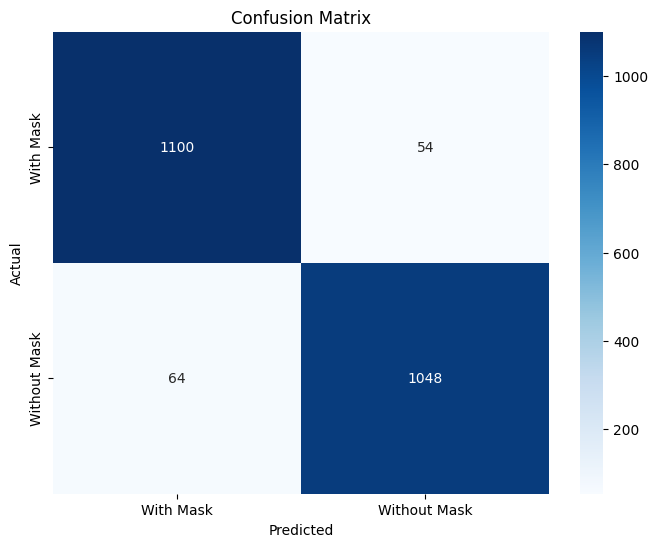

In [24]:
# Model Evaluation
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Performance Metrics
y_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred)


print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['With Mask', 'Without Mask'],
            yticklabels=['With Mask', 'Without Mask'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

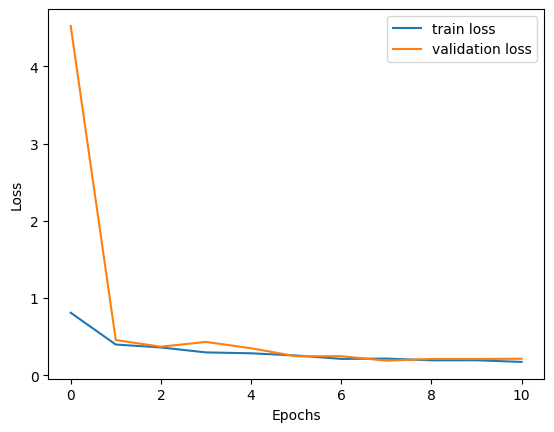

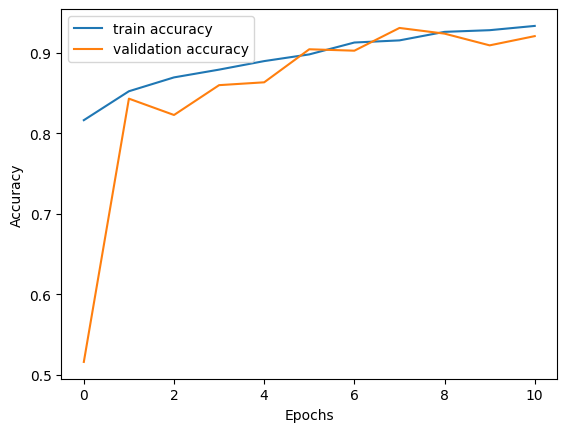

In [25]:
h = history

# Training Loss Curve
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training Accuracy curve
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Path of the image to be predicted: /content/test image 1.jpg


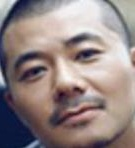

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
The person in the image is not wearing a mask (91.63% confidence).


In [23]:
# Predictive System - 1
input_image_path = input('Path of the image to be predicted: ')

input_image = cv.imread(input_image_path)

cv2_imshow(input_image)

input_image_resized = cv.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

prediction = model.predict(input_image_reshaped)
label = np.argmax(prediction)
confidence = np.max(prediction) * 100

if label == 0:
  print(f"The person in the image is wearing a mask ({confidence:.2f}% confidence).")
else:
  print(f"The person in the image is not wearing a mask ({confidence:.2f}% confidence).")

Path of the image to be predicted: /content/test image 2.jpg


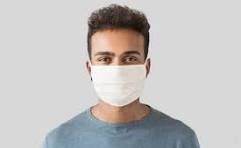

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The person in the image is wearing a mask (88.61% confidence).


In [24]:
# Predictive System - 2
input_image_path = input('Path of the image to be predicted: ')

input_image = cv.imread(input_image_path)

cv2_imshow(input_image)

input_image_resized = cv.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

prediction = model.predict(input_image_reshaped)
label = np.argmax(prediction)
confidence = np.max(prediction) * 100

if label == 0:
  print(f"The person in the image is wearing a mask ({confidence:.2f}% confidence).")
else:
  print(f"The person in the image is not wearing a mask ({confidence:.2f}% confidence).")